# КУРСОВОЙ ПРОЕКТ

Задача: предсказать цены на квартиры в датасете test.csv. Вам будут даны два датасета: train.csv (содержит признаки и цены на квартиры) и test.csv (только признаки).

**Подключение библиотек и скриптов**

In [278]:
import numpy as np
import pandas as pd
import random

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score as r2
from sklearn.model_selection import KFold, GridSearchCV

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

import warnings

**Установка параметров**

In [279]:
%matplotlib inline
warnings.filterwarnings('ignore')
matplotlib.rcParams.update({'font.size': 14})
pd.set_option('precision', 3)
pd.set_option('max_columns', 100)

**Пути к директориям и файлам**

In [280]:
TRAIN_DATASET_PATH = '/home/aiia_brain_domain/kdl_train.csv'
TEST_DATASET_PATH = '/home/aiia_brain_domain/kdl_test.csv'

**Вспомогательные функции (графики)**

In [281]:
def evaluate_preds(train_true_values, train_pred_values, val_true_values, val_pred_values):
    
    print("Train R2:\t" + str(round(r2(train_true_values, train_pred_values), 3)))
    print("Valid R2:\t" + str(round(r2(val_true_values, val_pred_values), 3)))
    
    plt.figure(figsize = (40,40))
    
    plt.subplot(121)
    sns.scatterplot(x = train_pred_values, y = train_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Train sample prediction')
    
    plt.subplot(122)
    sns.scatterplot(x = val_pred_values, y = val_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Test sample prediction')
    plt.show()

In [282]:
def trim_axs(axs, N):
    
    axs = axs.flat
    for ax in axs[N:]:
        ax.remove()
    return axs[:N]

def feature_scatter(df, features, feature_height = 10, feature_weight = 10):
    
    #строим максимум по 4 графика на строку
    
    feature_cols = len(features)
    max_rows = feature_cols // 4 + int(feature_cols % 4 > 0)
    
    figsize = (feature_height, feature_weight)
    
    fig1, axs = plt.subplots(max_rows, 4, figsize = figsize, constrained_layout = True)
    
    axs = trim_axs(axs, len(features))
    
    for ax, case in zip(axs, features):
    
        ax.set_title(case)
        ax.hist(df[case], 30, density = True)

## Изучение данных 

посмотрим на данные с разных ракурсов, составим общее представление

In [283]:
train_df = pd.read_csv(TRAIN_DATASET_PATH)
valid_df = pd.read_csv(TEST_DATASET_PATH)

In [284]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 20 columns):
Id               10000 non-null int64
DistrictId       10000 non-null int64
Rooms            10000 non-null float64
Square           10000 non-null float64
LifeSquare       7887 non-null float64
KitchenSquare    10000 non-null float64
Floor            10000 non-null int64
HouseFloor       10000 non-null float64
HouseYear        10000 non-null int64
Ecology_1        10000 non-null float64
Ecology_2        10000 non-null object
Ecology_3        10000 non-null object
Social_1         10000 non-null int64
Social_2         10000 non-null int64
Social_3         10000 non-null int64
Healthcare_1     5202 non-null float64
Helthcare_2      10000 non-null int64
Shops_1          10000 non-null int64
Shops_2          10000 non-null object
Price            10000 non-null float64
dtypes: float64(8), int64(9), object(3)
memory usage: 1.5+ MB


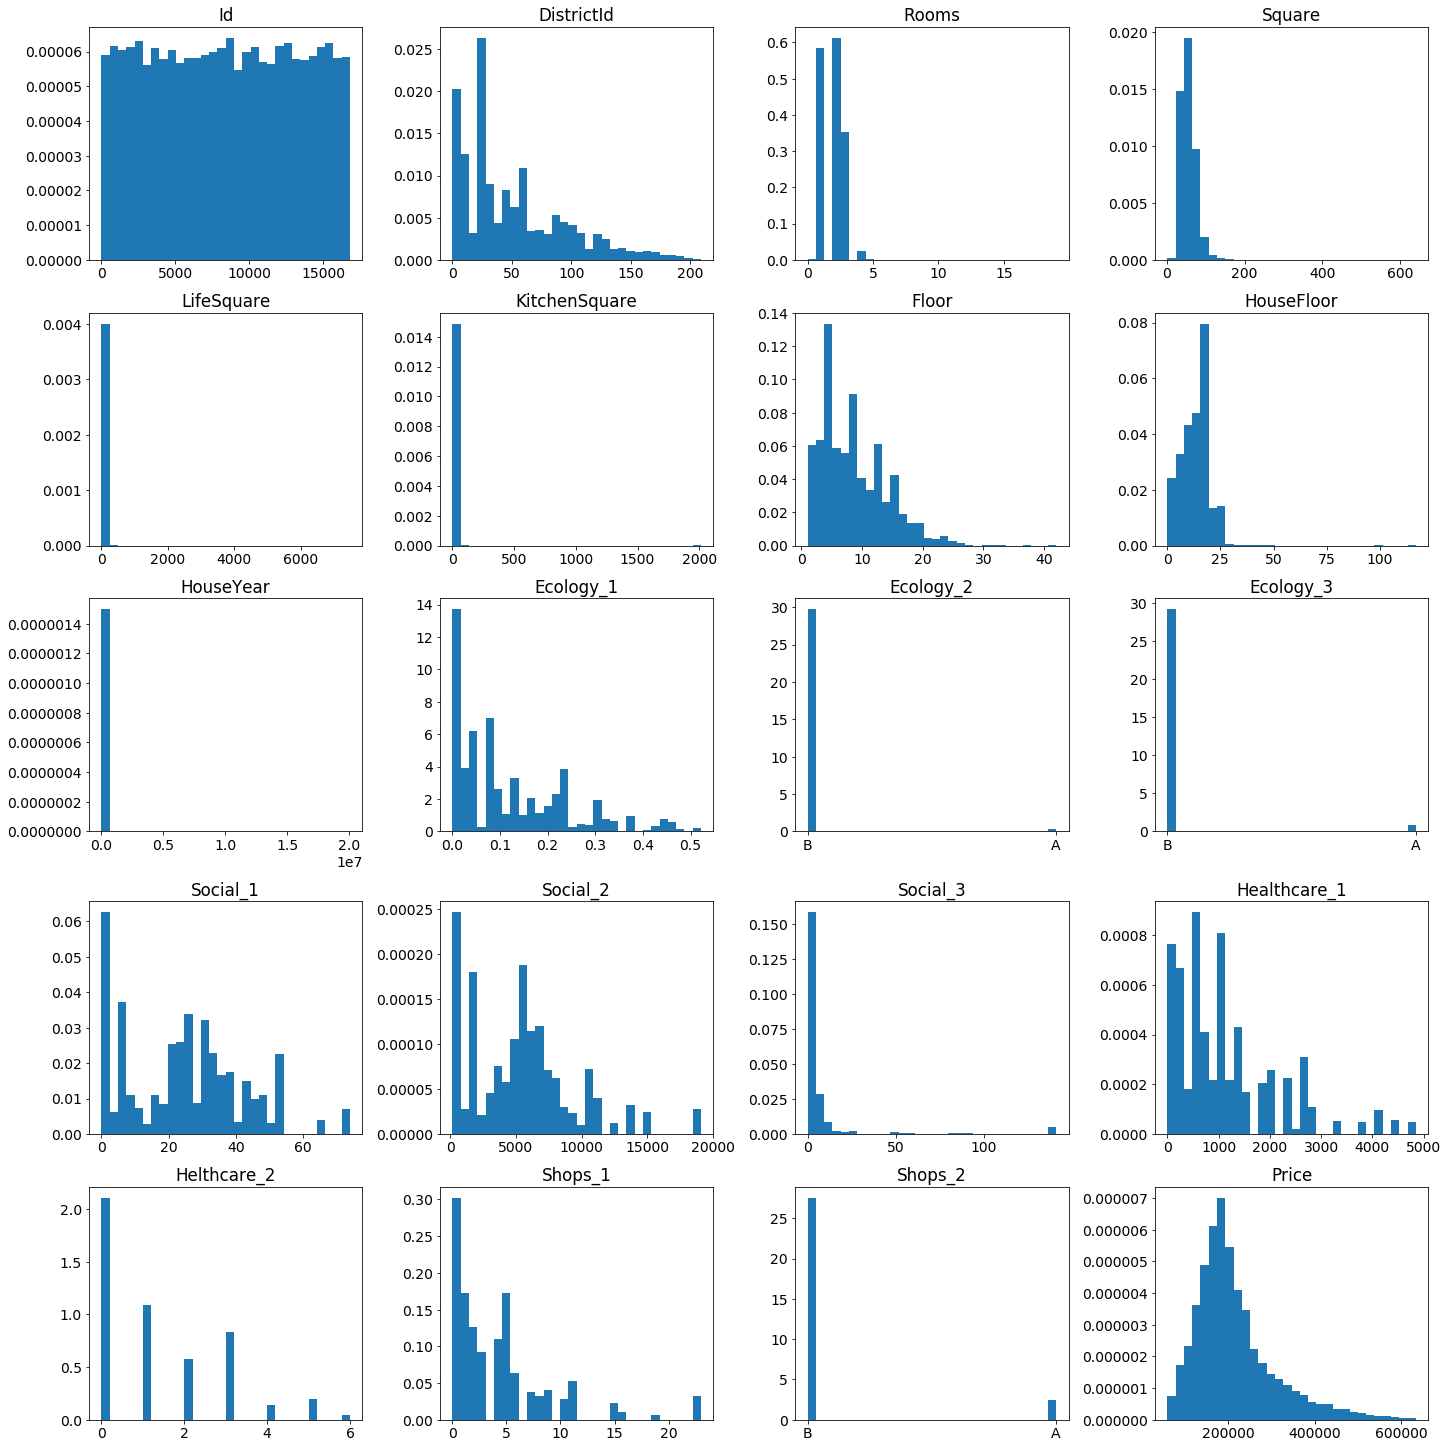

In [285]:
#плотность распределения показателей графически
feature_scatter(train_df, train_df.columns, 20, 20)

Основные выводы:

1. Пока нет претензий к: Price, DistrictId, Healfcare_1, Healfcare_2, Shops_1, Shops_2, Ecology_2, Ecology_3 и все... :(
2. Очень много нулевых значений, с которыми наверняка можно что-то сделать: KitchenSquare, DistrictId, HouseFloor  
3. Очень много незаполненных значений, бесперспективные: Social_1, Social_2, Social_3, Ecology_1
4. Явное присутствие выбросов, которые нужно скорректировать: LifeSquare, KitchenSquare, HouseFloor, Square, Rooms, HouseYear  
5. Пока ничего не понятно: Floor 

In [286]:
#анализ количественных показателей, для подтверждения выводов выше
train_df.describe().T

,count,mean,std,min,25%,50%,75%,max
Id,10000.0,8383.408,4859.019,0.000,4169.500,8394.500,12592.500,1.680e+04
DistrictId,10000.0,50.401,43.588,0.000,20.000,36.000,75.000,2.090e+02
Rooms,10000.0,1.891,0.840,0.000,1.000,2.000,2.000,1.900e+01
Square,10000.0,56.316,21.059,1.137,41.775,52.513,65.901,6.411e+02
LifeSquare,7887.0,37.200,86.241,0.371,22.770,32.781,45.129,7.481e+03
KitchenSquare,10000.0,6.273,28.561,0.000,1.000,6.000,9.000,2.014e+03
Floor,10000.0,8.527,5.241,1.000,4.000,7.000,12.000,4.200e+01
HouseFloor,10000.0,12.609,6.776,0.000,9.000,13.000,17.000,1.170e+02
HouseYear,10000.0,3990.166,200500.261,1910.000,1974.000,1977.000,2001.000,2.005e+07
Ecology_1,10000.0,0.119,0.119,0.000,0.018,0.075,0.196,5.219e-01


In [287]:
#Посмотрим на корреляцию показателей и цены. Пока не для изучения. Сравним с результатами после подготовки данных
train_df_corr = train_df.corr()
high_corr = train_df_corr[(np.abs(train_df_corr['Price']) > 0.1) & (np.abs(train_df_corr['Price']) !=1)]['Price']
print(high_corr)

DistrictId      0.265
Rooms           0.550
Square          0.520
Floor           0.129
Social_1        0.263
Social_2        0.239
Healthcare_1    0.139
Helthcare_2     0.253
Shops_1         0.181
Name: Price, dtype: float64


**Предварительный итог:**

* **Шаг 0:** Привести типы по рекомендациям вводного вебинара 
* **Шаг 1:** Нужно убрать выбросы LifeSquare, KitchenSquare, HouseFloor, Square, Rooms, HouseYear 
* **Шаг 2:** Посмотреть на строки с нулевыми значениями KitchenSquare, DistrictId, HouseFloor - что-то можно поправить
* **Шаг 3:** Обязательно добавить новые категории. Рабочими вариантами можно попробовать:
                 - Стоимость метра квадратного;
                 - Экология;
                 - Десятилетия (от года постройки дома).
* **Шаг 4:** RandomForestRegressor: постоить модель, посмотреть результат, тюнинг          
* **Шаг 5:** Не забыть попробовать отбросить Social_1, Social_2, Social_3, Ecology_1, сравнить R2

## Подготовка данных 

**Вспомогательные функции** (на основании выводов после изучения данных) 

детальное изучение - много графиков, убраны из проекта, чтобы не перегружать

In [288]:
def train_manual_correction(df):
    #Ручные корректировки, специфические для тренировочного датасета
    df['Rooms'] = np.where(df['Rooms'] > 8, 1, df['Rooms'])
    df.loc[df['HouseYear'] == 4968, 'HouseYear'] = 1968
    df.loc[df['HouseYear'] == 20052011, 'HouseYear'] = 2011
    
    df.loc[[590, 4690, 6977, 8437, 4262], 'LifeSquare'] = df.loc[[590, 4690, 6977, 8437, 4262], 'LifeSquare'] / 10
    df.loc[[4328], 'LifeSquare'] = df.loc[[4328], 'LifeSquare'] / 100

    df.loc[[4690, 6977, 4262], 'Square'] = df.loc[[4690, 6977, 4262], 'Square'] / 10
    


In [289]:
def test_manual_correction(df):
    #Ручные корректировки, специфические для тестового датасета
    df['Rooms'] = np.where(df['Rooms'] > 8, 1, df['Rooms'])
    df.loc[[410], 'LifeSquare'] = df.loc[[410], 'LifeSquare'] / 10

In [290]:
def normalize_type(df):
    
    df['Id'] = df['Id'].astype(str)
    df['DistrictId'] = df['DistrictId'].astype(str)
    
    df['Ecology_2_bin'] = df['Ecology_2'].replace({'A':0, 'B':1})
    df['Ecology_3_bin'] = df['Ecology_3'].replace({'A':0, 'B':1})
    df['Shops_2_bin'] = df['Shops_2'].replace({'A':0, 'B':1})
    

In [291]:
def drop_columns(df):
    
    columns = ['Id', 'Ecology_2', 'Ecology_3', 'Shops_2']
    
    for i in columns:
        df.drop(i, axis = 1, inplace = True)

In [292]:
def rooms_prep(df):
    df['Rooms'] = df['Rooms']
    rooms_mean = df[(df['Rooms'] < 6) & (df['Rooms'] > 0) & (df['Square'] < 200)].groupby('Rooms')['Square'].median()
    
    rooms_mean = pd.Series([40.0, 56.0, 77.0, 98.0, 115.0, 167.0], 
                            index = [1.0, 2.0, 3.0, 4.0, 5.0, 6.0])
  
    rooms_mean_rev = {v:k for k, v in rooms_mean.items()}

    for index, row in df[(df['Rooms'] == 0)].iterrows():
        df.loc[index, 'Rooms'] = rooms_mean_rev[min(rooms_mean, key = lambda x: abs(row['Square'] - x))]
            

In [293]:
def Square_prep(df):
    df['Square'] = df['Square']

In [294]:
def LifeSquare_prep(df):

    # медиана расхождения площадей
    square_med_diff = (df.loc[df['LifeSquare'].notnull(), 'Square']
                   - df.loc[df['LifeSquare'].notnull(), 'LifeSquare']
                   - df.loc[df['LifeSquare'].notnull(), 'KitchenSquare']).median()
    df.loc[df['LifeSquare'].isnull(), 'LifeSquare'] = (
        df.loc[df['LifeSquare'].isnull(), 'Square']
        - df.loc[df['LifeSquare'].isnull(), 'KitchenSquare']
        - square_med_diff
    )
    
    LS_avg = df[df['LifeSquare'] > 0].groupby('Rooms')['LifeSquare'].median()
    #df.loc[df['LifeSquare'].isnull(), 'LifeSquare'] = LS_avg[df['Rooms']]
    df['LifeSquare'] = np.where(df['LifeSquare'].isnull(), LS_avg[df['Rooms']], df['LifeSquare'])
    #df['LifeSquare'] = np.where((df['LifeSquare'] > df['Square']) & (df['KitchenSquare'] < df['LifeSquare']), df['Square'] - df['KitchenSquare'], df['LifeSquare'])
    

In [295]:
def KitchenSquare_prep(df):
    df['KitchenSquare'] = df['KitchenSquare']


In [296]:
def Healthcare_1_prep(df):
    df['Healthcare_1'] = df['Healthcare_1']
    H1_avg = df.groupby('DistrictId')['Healthcare_1'].median()
    df['Healthcare_1'] = np.where(df['Healthcare_1'] != df['Healthcare_1'], H1_avg[df['DistrictId']], df['Healthcare_1'])
    df['Healthcare_1'].fillna(df['Healthcare_1'].median() , inplace = True)
    

In [297]:
def Healthcare_2_prep(df):
    df['Helthcare_2'] = df['Helthcare_2']
    H1_avg = df.groupby('DistrictId')['Helthcare_2'].median()
    df['Helthcare_2'] = np.where((df['Helthcare_2'] != df['Helthcare_2']) | (df['Helthcare_2'] == 0), H1_avg[df['DistrictId']], df['Helthcare_2'])
    df['Helthcare_2'].fillna(df['Helthcare_2'].median() , inplace = True)
    df['Helthcare_2'] = np.where((df['Helthcare_2'] == 0), df['Helthcare_2'].median(), df['Helthcare_2'])

In [298]:
def add_cathegories(df):
    year_cathegories = [1910, 1920, 1940, 1950, 1960, 1970, 1980, 1990, 2000, 2010, 2020]
    df['HouseInterval'] = df['HouseYear'].apply(lambda x: min(year_cathegories, key = lambda y: abs(x - y)))
    
    
    #district_size = df['DistrictId'].value_counts().reset_index()\
    #           .rename(columns={'index':'DistrictId', 'DistrictId':'DistrictSize'})

    #district_size.head()
    
    #df = df.merge(district_size, on='DistrictId', how='left')
    #df['IsDistrictLarge'] = (df['DistrictSize'] > 100).astype(int)
    
    #df['DistrictId'] = np.where((df['IsDistrictLarge'] == 0), df['DistrictId'].median(), df['DistrictId'])
    i=1

In [299]:
def train_data_preparation(df):
    train_manual_correction(df)
    normalize_type(df)
    rooms_prep(df)
    KitchenSquare_prep(df)
    Square_prep(df)
    LifeSquare_prep(df)
    Healthcare_1_prep(df)
    #Healthcare_2_prep(df)
    add_cathegories(df)

In [300]:
def test_data_preparation(df):
    test_manual_correction(df)
    normalize_type(df)
    rooms_prep(df)
    KitchenSquare_prep(df)
    Square_prep(df)
    LifeSquare_prep(df)
    Healthcare_1_prep(df)
    #Healthcare_2_prep(df)
    add_cathegories(df)

## Основной алгоритм

In [301]:
train_df = pd.read_csv(TRAIN_DATASET_PATH)
valid_df = pd.read_csv(TEST_DATASET_PATH)

In [302]:
X = train_df.copy(deep = True)

In [303]:
#X.reset_index()
train_data_preparation(X)

In [304]:
df_stat = X.copy(deep = True)

In [305]:
drop_columns(X)
X.drop("Price", axis = 1, inplace = True)

In [306]:
X_train, X_test, y_train, y_test = train_test_split(X, train_df['Price'], test_size = 0.16, random_state = 42)

In [307]:
#from sklearn.ensemble import GradientBoostingRegressor
#parameters =  [{'n_estimators': np.arange(100, 1000, 100), 'max_features': np.arange(5, 15, 2), 'max_depth': np.arange(10, 25, 2), 'random_state':[42]}]
#GSCV_models = GridSearchCV(estimator = GradientBoostingRegressor(), param_grid = parameters, n_jobs = -1, scoring = 'r2')
#GSCV_models.fit(X_train, y_train)
#GSCV_models.best_params_

In [308]:
from sklearn.ensemble import GradientBoostingRegressor
#{'max_depth': 10, 'max_features': 5, 'n_estimators': 100, 'random_state': 42}
#model = RandomForestRegressor(n_estimators = 600, max_depth = 18, random_state = 42, max_features = 7)
model = GradientBoostingRegressor(n_estimators = 200, max_depth = 5, random_state = 42)
#model = GradientBoostingRegressor(n_estimators = 100, max_depth = 10, random_state = 42, max_features = 5)

In [309]:
model.fit(X_train, y_train)

GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.1, loss='ls', max_depth=5,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=200,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=42, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

In [310]:
у_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

## Оценка 

In [311]:
from sklearn.metrics import r2_score
r2_score(y_test, y_test_pred)

0.7511443457807878

Train R2:	0.894
Valid R2:	0.751


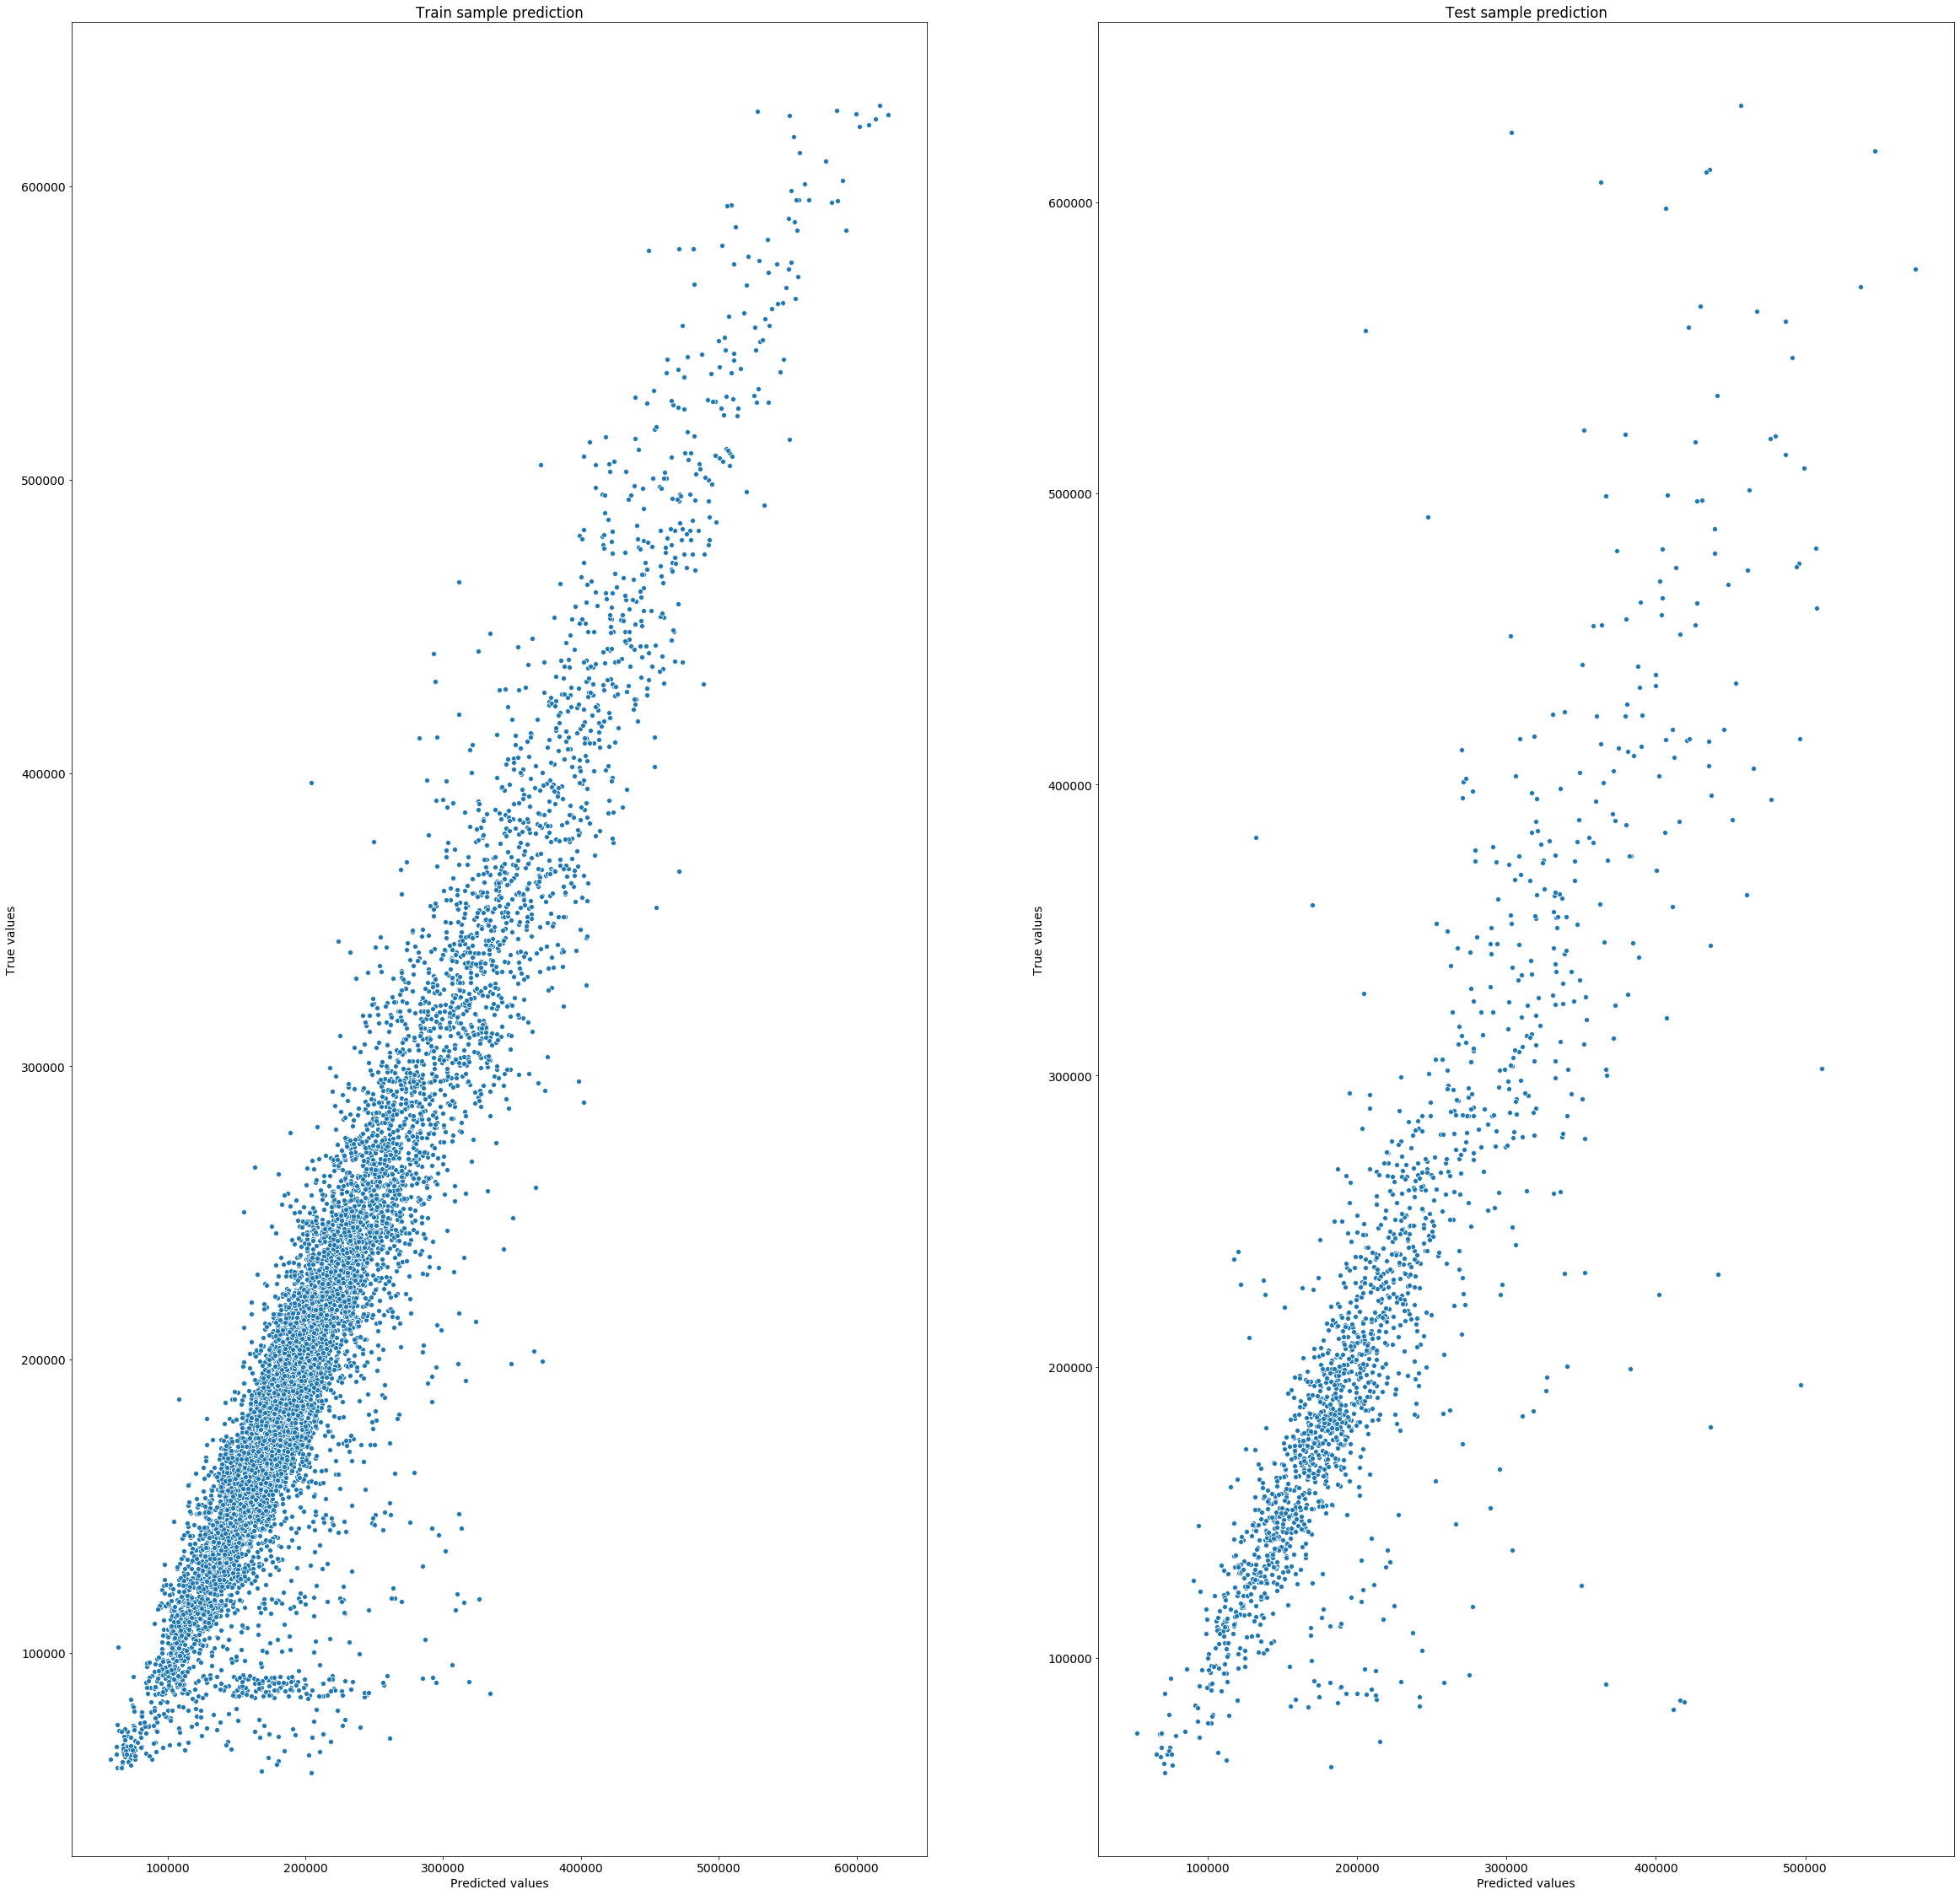

In [312]:
evaluate_preds(y_train, у_train_pred, y_test, y_test_pred)

## Финальный результат - выгрузка 

In [313]:
X_valid = valid_df.copy(deep = True)
test_data_preparation(X_valid)
drop_columns(X_valid)

In [314]:
y_valid = model.predict(X_valid)

In [315]:
pd.DataFrame({'Id':valid_df['Id'], 'Price':y_valid}).to_csv('VAlekseev_submission - 023.csv', index = False)

## Эксперименты 

раздел удален перед отправкой на проверку